In [7]:
import pandas as pd
from models import base_res_net, small_res_net, efficient_net, pretrained_mobilenet, big_model, xception_net
import tensorflow as tf
import tensorflow.compat.v1 as tfc
from sklearn.utils.class_weight import compute_class_weight

import random
from modeling import predict, predict_from_csv, prob_predict, stack_predictions
from src import InputPipeline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Check GPU for tf

In [2]:
# Some GPU setup
# for documentation about using gpus refer to: https://www.tensorflow.org/install/pip#windows-wsl2

tf.keras.backend.clear_session()

device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
try:  # prevent a previous session from being alive
  sess.close() 
except:
  pass

tfc.enable_eager_execution()
gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.80)
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))

### Optional Stuff
- Here we compute classweights since the data is very imbalanced

In [3]:
train_df = pd.read_csv("./data/train_images_stratified.csv")

In [4]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = train_df["label"].unique(), y=train_df["label"])
class_weights = dict(enumerate(class_weights))

## Configure Parameters

In [14]:
#INPUT_SHAPE = (220,220,3)
INPUT_SHAPE = (220,220,3)

CONF = {
  "learning_rate": 0.0001,
  "batch_size": 48,
  "epochs": 20,
  "loss_function": "sparse_categorical_crossentropy",
  "metric": "sparse_categorical_accuracy",
}

## Make Input Pipelines

In [6]:
# Input pipeline for subspecies
sub_species_input_pipeline = InputPipeline(splits=(0.85,0.0,0.15), channels=3, batch_size=CONF["batch_size"], size=INPUT_SHAPE[:2])
# This has a stratified split
sub_species_input_pipeline.make_stratified_train_dataset(
  train_ds_path= "./data/train_ds_images_stratified.csv",
  val_ds_path="./data/val_ds_images_stratified.csv",
)


# Input pipeline for species
species_input_pipeline = InputPipeline(splits=(0.85,0.0,0.15), channels=3, batch_size=CONF["batch_size"], size=INPUT_SHAPE[:2])
species_input_pipeline.make_train_datasets(directory="./data/train_images/species_classify")  # This doesnt have a stratified split


Datasets populated!
Found 43186 files belonging to 70 classes.
Using 36709 files for training.
Using 6477 files for validation.
Datasets populated!


## Training a Model

In [9]:
from modeling import train_classifier

In [16]:
# making the species classifier
train_classifier(
  model_name="./classifiers/eff_net_hyptunning_25e",
  input_shape=INPUT_SHAPE,  
  classes_to_classify=200,
  configuration=CONF,
  model=efficient_net, 
  train_dataset=sub_species_input_pipeline.train_dataset,
  validation_dataset=sub_species_input_pipeline.validation_dataset,
)

Folder './classifiers/' already exists.
Folder './classifiers/trainHistoryDict' already exists.
Epoch 1/20
343/343 [==============================] - 65s 169ms/step - loss: 7.1251 - sparse_categorical_accuracy: 0.2238 - val_loss: 4.0465 - val_sparse_categorical_accuracy: 0.5157
Epoch 2/20
343/343 [==============================] - 55s 161ms/step - loss: 3.9686 - sparse_categorical_accuracy: 0.4171 - val_loss: 3.3431 - val_sparse_categorical_accuracy: 0.5721
Epoch 3/20
343/343 [==============================] - 58s 166ms/step - loss: 3.6176 - sparse_categorical_accuracy: 0.4573 - val_loss: 3.1837 - val_sparse_categorical_accuracy: 0.5890
Epoch 4/20
343/343 [==============================] - 58s 166ms/step - loss: 3.4666 - sparse_categorical_accuracy: 0.4789 - val_loss: 3.0832 - val_sparse_categorical_accuracy: 0.5997
Epoch 5/20
343/343 [==============================] - 55s 161ms/step - loss: 3.3849 - sparse_categorical_accuracy: 0.4903 - val_loss: 3.0743 - val_sparse_categorical_accura

INFO:tensorflow:Assets written to: ./classifiers/eff_net_hyptunning_25e\assets


INFO:tensorflow:Assets written to: ./classifiers/eff_net_hyptunning_25e\assets


Model saved successfully under: ./classifiers/eff_net_hyptunning_25e


In [8]:
# making the species classifier
train_classifier(
  model_name="./classifiers/species_efficient_net_classifier_50e",
  input_shape=INPUT_SHAPE,
  classes_to_classify=70,
  configuration=CONF,
  model=efficient_net, 
  train_dataset=species_input_pipeline.train_dataset,
  validation_dataset=species_input_pipeline.validation_dataset,
)

Folder './classifiers/' already exists.
Folder './classifiers/trainHistoryDict' already exists.
Epoch 1/25
765/765 [==============================] - 282s 357ms/step - loss: 9.0706 - sparse_categorical_accuracy: 0.2969 - val_loss: 6.7043 - val_sparse_categorical_accuracy: 0.5158
Epoch 2/25
765/765 [==============================] - 247s 323ms/step - loss: 5.8266 - sparse_categorical_accuracy: 0.4800 - val_loss: 4.5862 - val_sparse_categorical_accuracy: 0.6009
Epoch 3/25
765/765 [==============================] - 251s 328ms/step - loss: 4.1511 - sparse_categorical_accuracy: 0.5549 - val_loss: 3.3820 - val_sparse_categorical_accuracy: 0.6461
Epoch 4/25
765/765 [==============================] - 241s 314ms/step - loss: 3.2008 - sparse_categorical_accuracy: 0.5976 - val_loss: 2.6985 - val_sparse_categorical_accuracy: 0.6789
Epoch 5/25
765/765 [==============================] - 229s 299ms/step - loss: 2.6536 - sparse_categorical_accuracy: 0.6262 - val_loss: 2.3100 - val_sparse_categorical_a

INFO:tensorflow:Assets written to: ./classifiers/species_efficient_net_classifier_50e\assets


INFO:tensorflow:Assets written to: ./classifiers/species_efficient_net_classifier_50e\assets


Model saved successfully under: ./classifiers/species_efficient_net_classifier_50e


## NN results

In [93]:
import pickle 
import matplotlib.pyplot as plt
import pandas as pd

with open("./classifiers/trainHistoryDict/subspecies_effnet_250_classifier_100e.pkl", 'rb') as file:
    history = pickle.load(file)

history_df = pd.DataFrame(history)

In [9]:
history_df.head()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,9.070608,0.296875,6.704267,0.515825
1,5.826646,0.479964,4.586219,0.600895
2,4.151052,0.554932,3.381986,0.646132
3,3.200785,0.597592,2.698540,0.678864
4,2.653592,0.626195,2.310050,0.690134


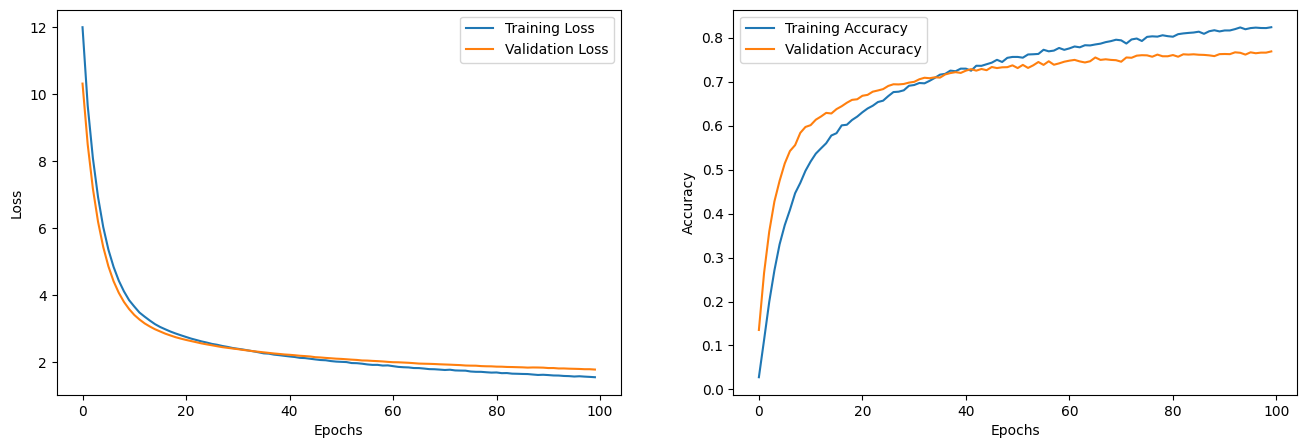

In [94]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,5))

# Plot for ax1
ax1.plot(history_df["loss"], label='Training Loss')
ax1.plot(history_df["val_loss"], label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot for ax2
ax2.plot(history_df["sparse_categorical_accuracy"], label='Training Accuracy')
ax2.plot(history_df["val_sparse_categorical_accuracy"], label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

## Predict Stuff

In [40]:
# No label adjustments needed afterwards!!!!!!
predict_from_csv(
  subspecies_classifier="./classifiers/subspecies_effnet_250_classifier_100e",
  dataset="./data/test_images_path.csv",
  path="./data/test_images",
  size=INPUT_SHAPE,
)

predicting: 100%|██████████| 4000/4000 [05:08<00:00, 12.95it/s]

Saving to: ./data/test_images_sample_1701862387.688046.csv


In [18]:
check = "./classifiers/subspecies_effnet_250_classifier_100e"

check.split("/")[-1]

'subspecies_effnet_250_classifier_100e'

## Stacking

In [8]:
species_preds = prob_predict(classifier="./classifiers/species_efficient_net_classifier_50e",
            dataset="./data/test_images_path.csv",
            path="./data/test_images",
            size=INPUT_SHAPE,
            )

predicting: 100%|██████████| 4000/4000 [07:29<00:00,  8.90it/s]


In [10]:
subspecies_preds = prob_predict(classifier="./classifiers/subspecies_effnet_250_classifier_100e",
            dataset="./data/test_images_path.csv",
            path="./data/test_images",
            size=INPUT_SHAPE,
            )

predicting: 100%|██████████| 4000/4000 [07:56<00:00,  8.39it/s]


In [82]:
species_preds.head()

,image_path,label,proba,max_prob,class_pred,expanded_prob
id,,,,,,
1,/test_images/999.jpg,1,"[[1.0757253e-05, 3.8058768e-06, 2.08436e-05, 0...",0.947471,28,"[2.434482485114131e-05, 2.434482485114131e-05,..."
2,/test_images/998.jpg,1,"[[0.00041660087, 0.00032023917, 0.00018287338,...",0.784894,17,"[0.00015740108210593462, 0.0001574010821059346..."
3,/test_images/997.jpg,1,"[[0.00040051193, 0.0012222049, 6.451746e-05, 0...",0.838085,30,"[0.00016391674580518156, 0.0001639167458051815..."
4,/test_images/996.jpg,1,"[[5.278277e-06, 7.1089194e-06, 7.226245e-05, 0...",0.993572,4,"[1.1981306670350023e-05, 1.1981306670350023e-0..."
5,/test_images/995.jpg,1,"[[7.909764e-05, 7.405577e-05, 2.307529e-06, 0....",0.985312,30,"[8.784902456682175e-05, 8.784902456682175e-05,..."


In [56]:
subspecies_preds.head()

,image_path,label,proba,max_prob,class_pred,combined_class_pred
id,,,,,,
1,/test_images/999.jpg,1,"[[8.116693e-07, 2.9847076e-06, 2.7479325e-06, ...",0.660688,67,67
2,/test_images/998.jpg,1,"[[1.0035847e-05, 4.539881e-06, 1.8316654e-05, ...",0.155374,40,40
3,/test_images/997.jpg,1,"[[1.0666555e-05, 5.947721e-07, 0.00010206009, ...",0.870824,74,74
4,/test_images/996.jpg,1,"[[9.02112e-08, 6.683589e-08, 9.654332e-09, 5.7...",0.999869,12,12
5,/test_images/995.jpg,1,"[[4.291657e-06, 7.37072e-07, 3.156306e-05, 4.2...",0.950021,74,74


In [125]:
result = stack_predictions(species_df = species_preds, subspecies_df = subspecies_preds, species_weight=(1), subspecies_weight=(0.3))

In [126]:
result[result["class_pred"]==result["combined_class_pred"]]

,image_path,label,proba,max_prob,class_pred,combined_class_pred
id,,,,,,
1,/test_images/999.jpg,1,"[[8.116693e-07, 2.9847076e-06, 2.7479325e-06, ...",0.660688,67,67
2,/test_images/998.jpg,1,"[[1.0035847e-05, 4.539881e-06, 1.8316654e-05, ...",0.155374,40,40
3,/test_images/997.jpg,1,"[[1.0666555e-05, 5.947721e-07, 0.00010206009, ...",0.870824,74,74
4,/test_images/996.jpg,1,"[[9.02112e-08, 6.683589e-08, 9.654332e-09, 5.7...",0.999869,12,12
5,/test_images/995.jpg,1,"[[4.291657e-06, 7.37072e-07, 3.156306e-05, 4.2...",0.950021,74,74
...,...,...,...,...,...,...
3996,/test_images/1001.jpg,1,"[[1.4920279e-05, 0.00015527118, 0.00025089414,...",0.468822,160,160
3997,/test_images/1000.jpg,1,"[[2.3026662e-06, 1.2521453e-05, 1.9680674e-06,...",0.474858,98,98
3998,/test_images/100.jpg,1,"[[2.4344438e-06, 6.066472e-05, 8.840729e-06, 1...",0.630290,135,135


In [128]:
result["combined_class_pred"].to_csv("species_stacking.csv")